In [113]:
# Libreria para lógica difusa
!pip install scikit-fuzzy==0.5.0

In [114]:
# Librerías complementarias para trabajar con números y gráficos y llamar a las funciones de la libreria anterior
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt


# PARTE 1

In [115]:
# Definición de los antecedentes (entradas) y consecuente (salida)
quality = ctrl.Antecedent(np.arange(0, 11, 1), 'quality')
service = ctrl.Antecedent(np.arange(0, 11, 1), 'service')
tip = ctrl.Consequent(np.arange(0, 26, 1), 'tip')


In [116]:
# Generación automática de funciones de pertenencia de las entradas
quality.automf(3)
service.automf(3)


In [117]:
# Definición manual de la función de pertenencia para la salida, indicando que rangos pertenencen a cada etiqueta
tip['low'] = fuzz.trimf(tip.universe, [0, 0, 13])
tip['medium'] = fuzz.trimf(tip.universe, [0, 13, 25])
tip['high'] = fuzz.trimf(tip.universe, [13, 25, 25])


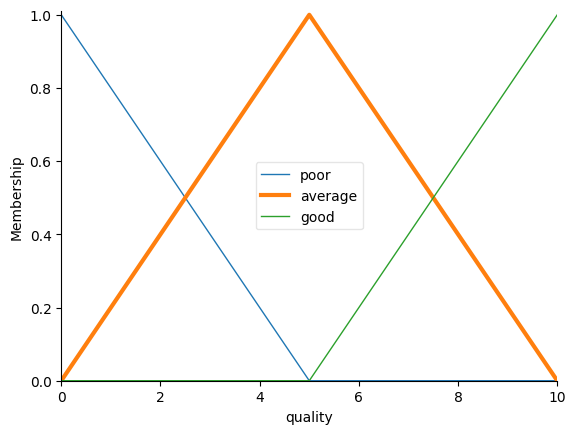

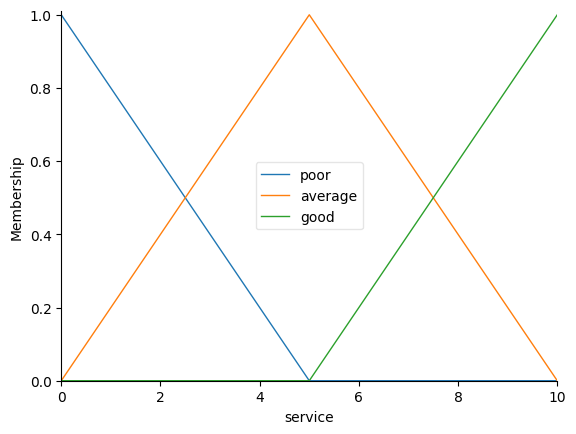

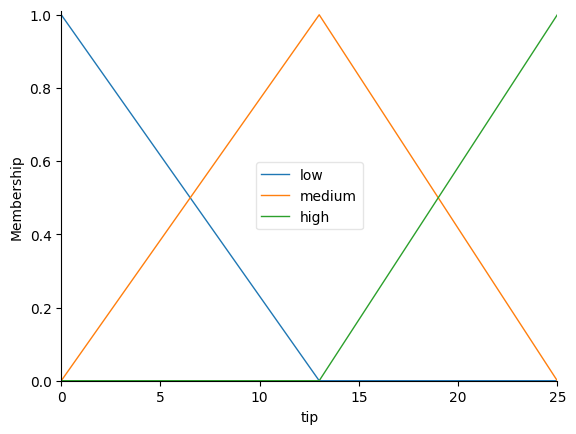

In [118]:
# graficación de las funciones de pertenencia para las entradas y la salida
quality['average'].view()
service.view()
tip.view()
plt.show()




In [119]:
# Definición de las reglas del sistema difuso
rule1 = ctrl.Rule(quality['poor'] | service['poor'], tip['low'])
rule2 = ctrl.Rule(service['average'], tip['medium'])
rule3 = ctrl.Rule(service['good'] | quality['good'], tip['high'])

In [120]:
# Creación del sistema de control para ejecutar las reglas simultaneamente y de la simulación para calcular la salida
tipping_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])

tipping = ctrl.ControlSystemSimulation(tipping_ctrl)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


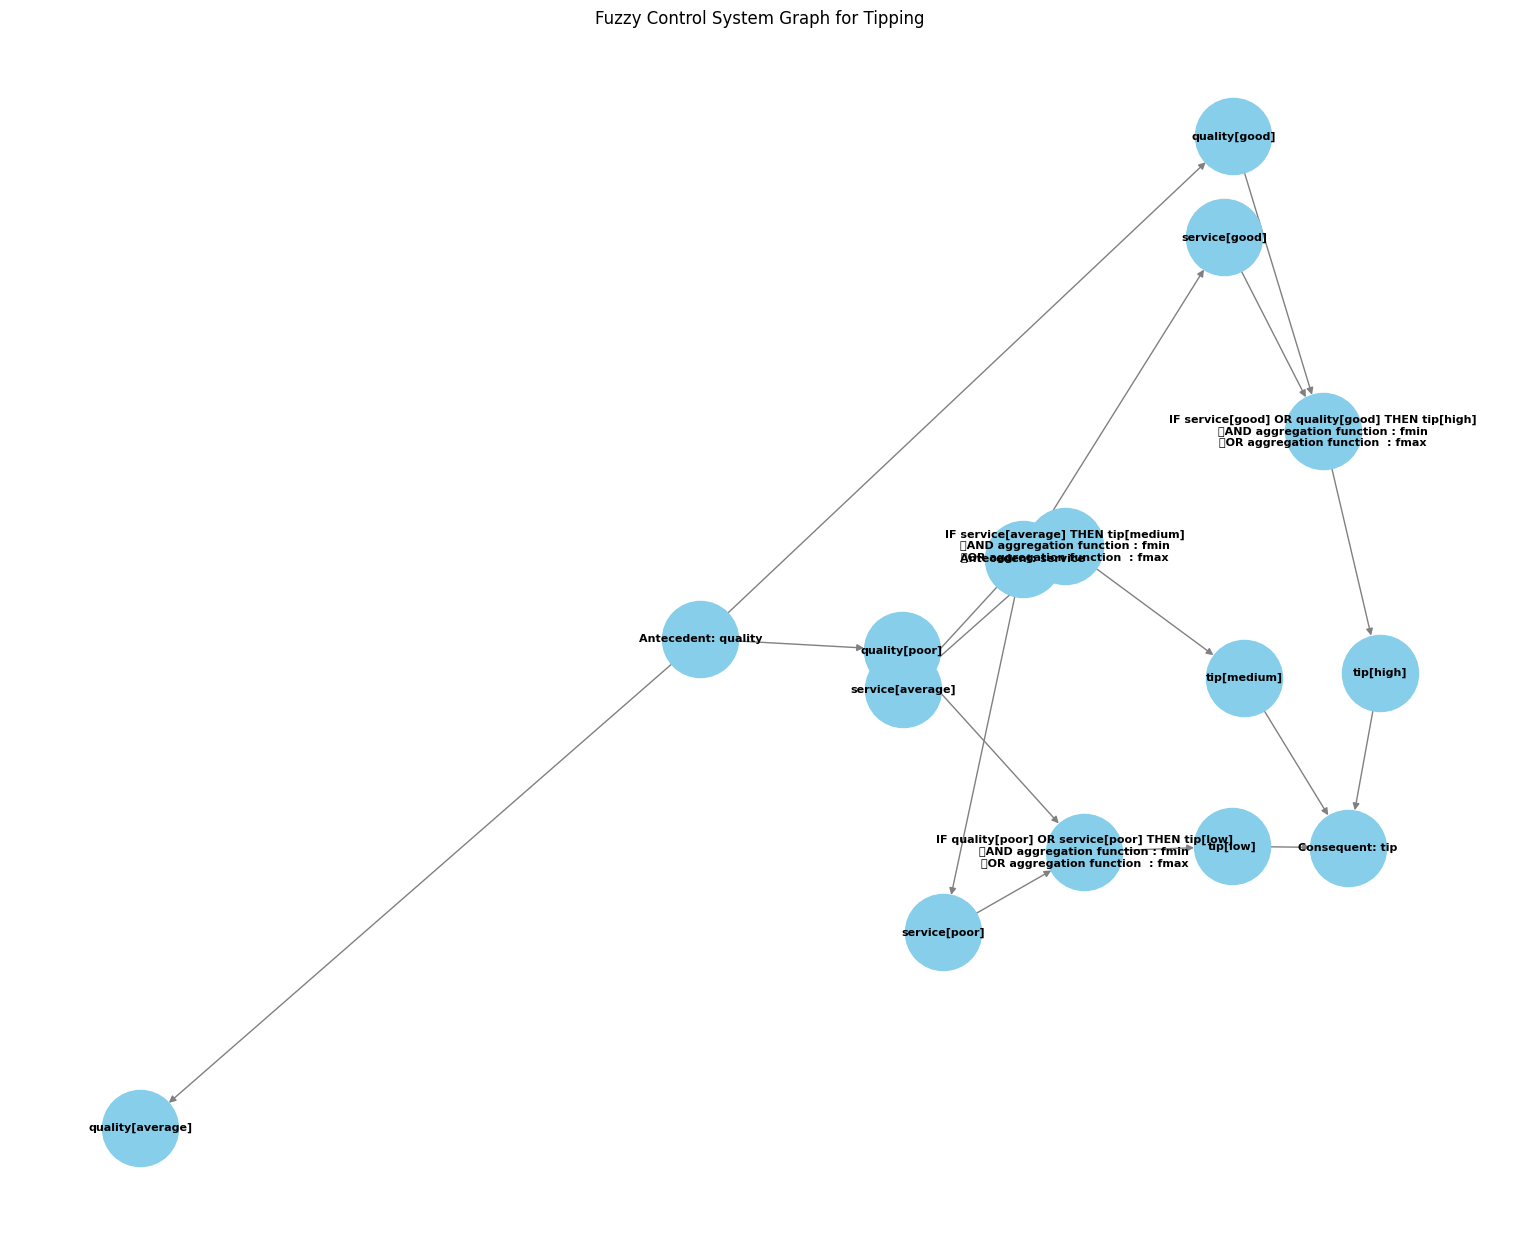

In [121]:
import networkx as nx # Import networkx to draw the graph directly

# The original tipping_ctrl.view() caused an AttributeError, likely a library bug.
# We will directly draw the underlying NetworkX graph.
# tipping_ctrl.view() # This line caused the error

# Access the underlying NetworkX graph from the ControlSystem object
graph = tipping_ctrl.graph

# Draw the graph using networkx
plt.figure(figsize=(15, 12)) # Increased figure size for better visualization
pos = nx.spring_layout(graph) # Use a layout algorithm for better readability
nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=3000,
        font_size=8, font_weight='bold', edge_color='gray', arrows=True)

plt.title("Fuzzy Control System Graph for Tipping")
plt.show()

19.847607361963192


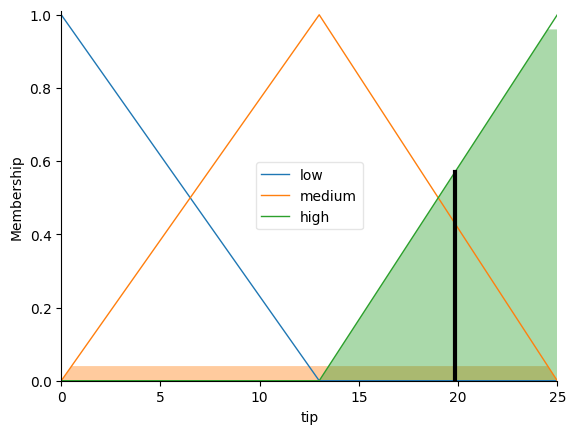

In [122]:
# Ejemplo con valores y proceso de defuzzificación
tipping.input['quality'] = 6.5
tipping.input['service'] = 9.8


tipping.compute()

print(tipping.output['tip'])
#> 19.847607361963192
tip.view(sim=tipping)

plt.show()



# PARTE 2


In [159]:
# Definición de los antecendentes, entradas (temperature,soc,sgrid) y consecuente, salida (protection)
temperature = ctrl.Antecedent(np.arange(-20, 21, 1), 'temperature')
soc = ctrl.Antecedent(np.arange(0, 101, 1), 'soc')
sgrid = ctrl.Antecedent(np.arange(-1, 1.1, 0.1), 'sgrid') # -1 Demanda/Descargar  , 0 Neutro , 1 Excedente/Cargar
protection = ctrl.Consequent(np.arange(0, 11, 1), 'Protection')

In [160]:
# Antecendes, es decir, entradas
# Temperatura en -5ºC (Frozen) empieza a bjar, Cold empieza a subir. En 0ªC sería el punto de cruce más critico.
# Frozen llega a 0 y Cold esta en su pico (1), y empieza a subir a Safe
temperature['Frozen'] = fuzz.trapmf(temperature.universe, [-20, -20, -5, 0])
temperature['Cold']        = fuzz.trimf(temperature.universe, [-5, 0, 5])
temperature['Safe']      = fuzz.trapmf(temperature.universe, [0, 5, 20, 20])

# SoC (Batería), se han utilizado todo funciones trapezoidales para cubrir mejor el problema
soc['Low'] = fuzz.trapmf(soc.universe, [0, 0, 15,40])
soc['Medium']   = fuzz.trapmf(soc.universe, [15, 40, 60, 85])
soc['High']    = fuzz.trapmf(soc.universe, [60, 85, 100, 100])

# Red, se ha utilizado función trapezoidal también
sgrid['Demand'] = fuzz.trapmf(sgrid.universe, [-1, -1, -0.5, 0]) # Podemos descargar
sgrid['Balanced'] = fuzz.trimf(sgrid.universe, [-0.5, 0, 0.5]) # no hacemos nada
sgrid['Exceed'] = fuzz.trapmf(sgrid.universe, [0, 0.5, 1, 1])     # Podemos cargar

In [161]:
# Consecuente, es decir, la salida
protection['standby'] = fuzz.trapmf(protection.universe, [0, 0, 3, 5]) # De 0 a 3 es 100% standby, no hace nada la bateria. En 5 empezaría a moverse
protection['recirculation'] = fuzz.trimf(protection.universe, [2, 5, 8]) # En 5 es el pico máximo. Aquí las bombas giran pero NO cargamos/descargamos.
protection['heating'] = fuzz.trapmf(protection.universe, [5, 7, 10, 10]) # Empieza en 5. De 7 a 10 es 100% Heating

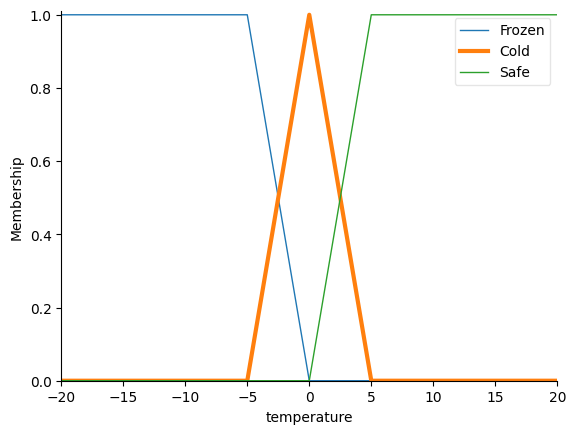

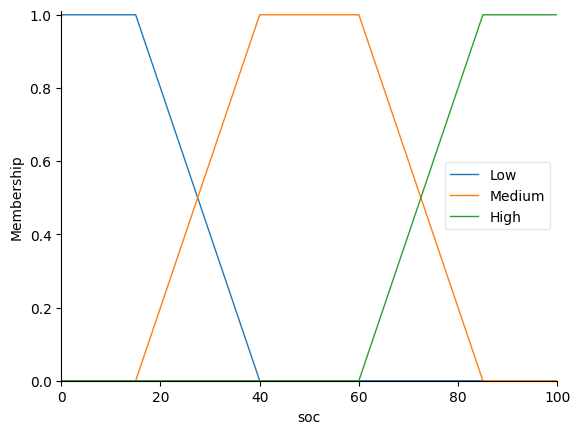

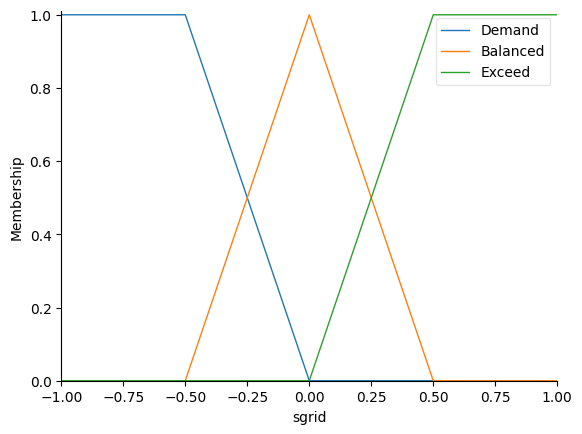

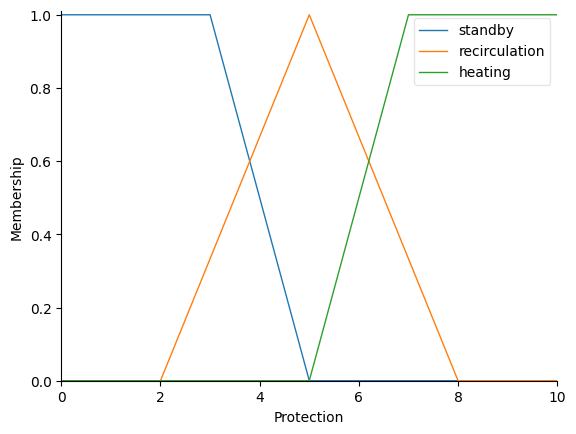

In [162]:
temperature['Cold'].view()
soc.view()
sgrid.view()
protection.view()
plt.show()

In [176]:
#Definimos alguns reglas
# R1: Si hace bajo cero Y la batería está vacía Y red neutra (sin excedentes) -> SOLO RECIRCULAR (No podemos cargar, ni descargar)
rule1 = ctrl.Rule(temperature['Frozen']  & soc['Low']  & sgrid['Balanced'] , protection['recirculation'])
# R2: Si hace bajo cero Y tenemos batería bastante cargada y red neutra (sin excedentes) -> CALENTAR (Descarga, ya que como el SOC es alto, se puede descargar)
rule2 = ctrl.Rule(temperature['Frozen'] & soc['High']  & sgrid['Balanced'], protection['heating'])
# R3: Si hace "frio" (no congelado) Y batería a mitad y hay excedente de red -> CALENTAR (Cargar, se puede cargar porque hay excedente en la red)
rule3 = ctrl.Rule(temperature['Cold'] & soc['Medium'] & sgrid['Exceed'], protection['heating'])
# R4: Si no hace malo(safe, ni frio ni calor) Y batería muy baja y hay excedente de red -> CALENTAR (Cargar, se puede cargar porque hay excedente en la red)
rule4 = ctrl.Rule(temperature['Frozen'] & soc['Low'] & sgrid['Exceed'], protection['heating'])
# R5: Si la temperatura es normal (temperatura media) y el estado de la red neutro -> STANDBY (Ahorro energía, no hace nada)
rule5 = ctrl.Rule(temperature['Safe'] & sgrid['Balanced'], protection['standby'])


In [177]:
#Creación del sistema de control para ejecutar las reglas simultaneamente y de la simulación para calcular la salida
battery_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])

battery = ctrl.ControlSystemSimulation(battery_ctrl)

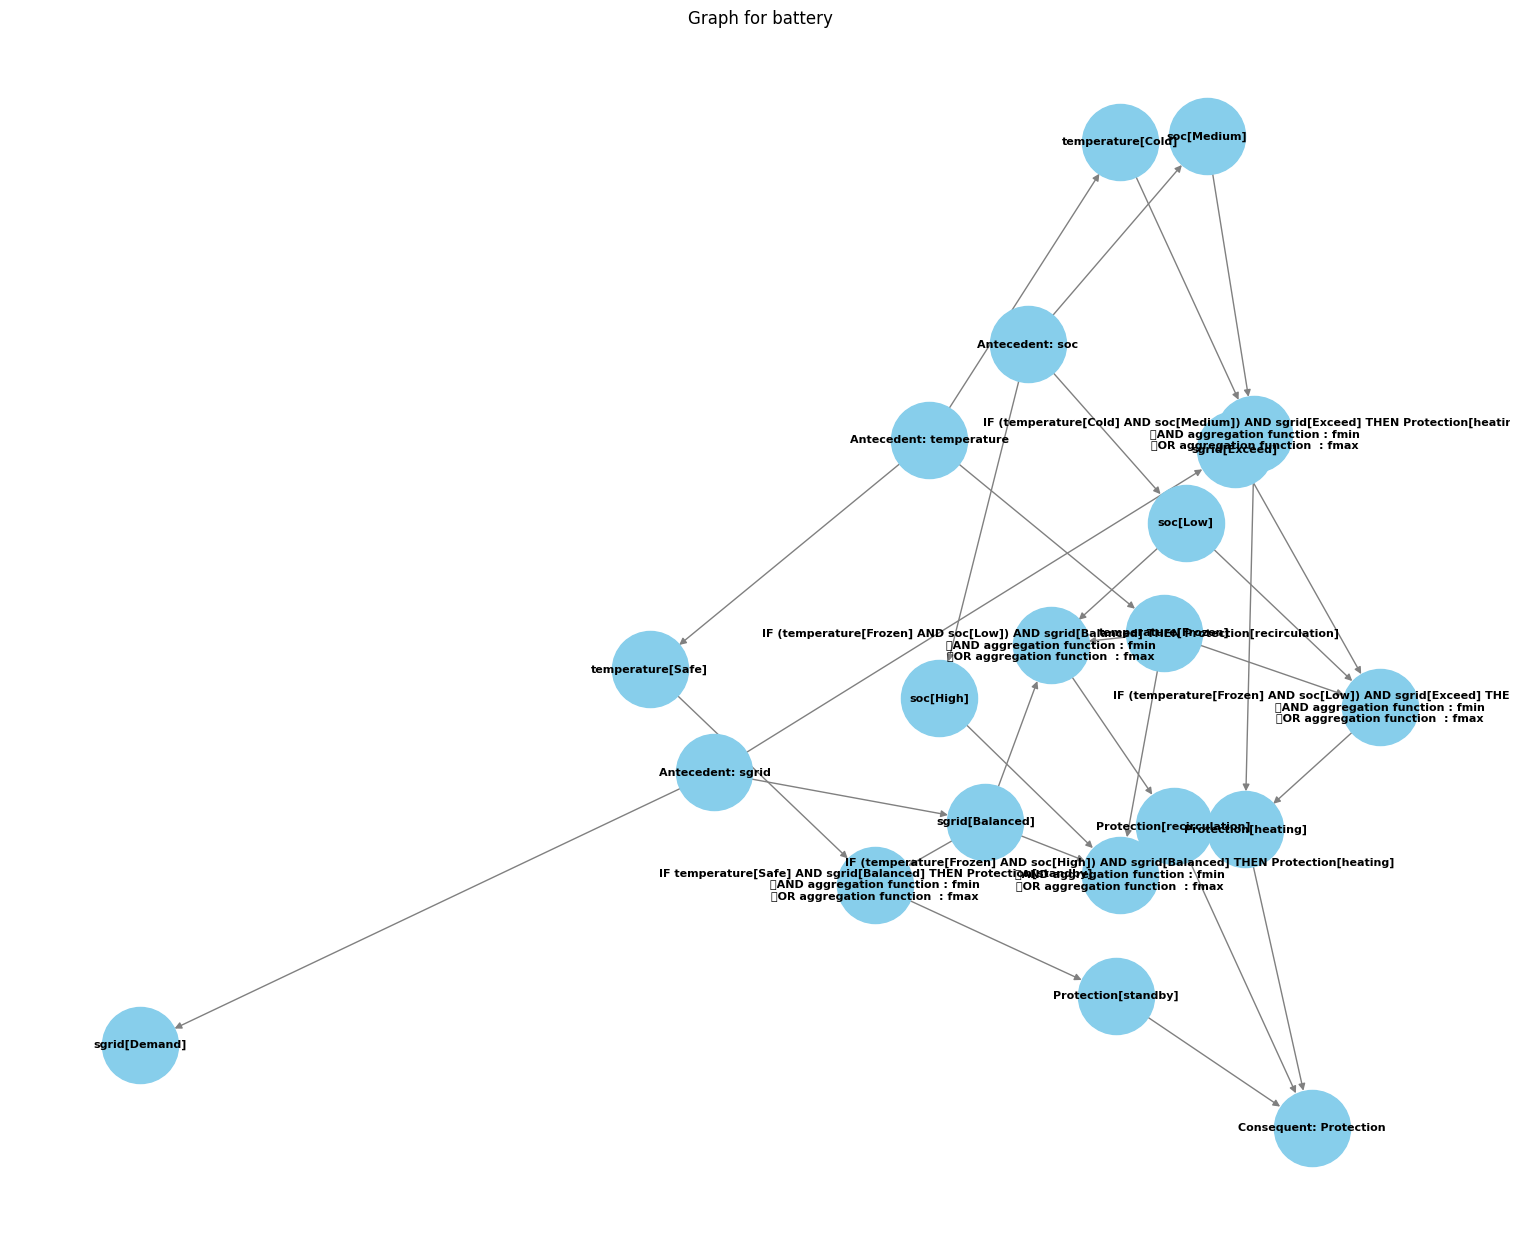

In [183]:
import networkx as nx # Importamos la libreria network para crear el grafo


#
graph = battery_ctrl.graph

# Dibujamos el grafo
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=3000,
        font_size=8, font_weight='bold', edge_color='gray', arrows=True)

plt.title("Graph for battery")
plt.show()

5.0


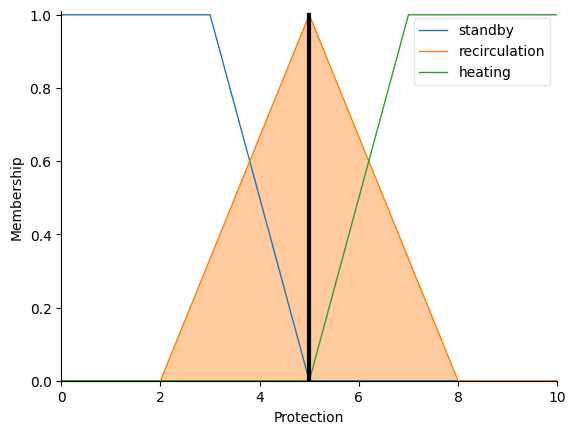

In [189]:
# La temperatura es negativa (se puede congelar el electrolito), y la bateria
# esta muy baja y  no hay excedente de red, por lo que tendría que recircular
battery.input['temperature'] = -10
battery.input['soc'] = 10
battery.input['sgrid'] = 0

# Crunch the numbers
battery.compute()

print(battery.output['Protection'])

protection.view(sim=battery)

plt.show()

7.786363636363636


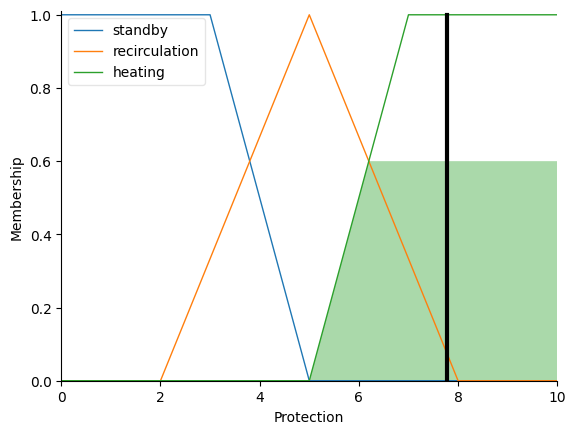

In [190]:
# La temperatura es negativa (se puede congelar el electrolito), la bateria esta bastante cargada
# y hay excedente, por lo que se juega con la descarga para calentarla
battery.input['temperature'] = -1
battery.input['soc'] = 70
battery.input['sgrid'] = 1

# Crunch the numbers
battery.compute()

print(battery.output['Protection'])

protection.view(sim=battery)

plt.show()

2.0416666666666674


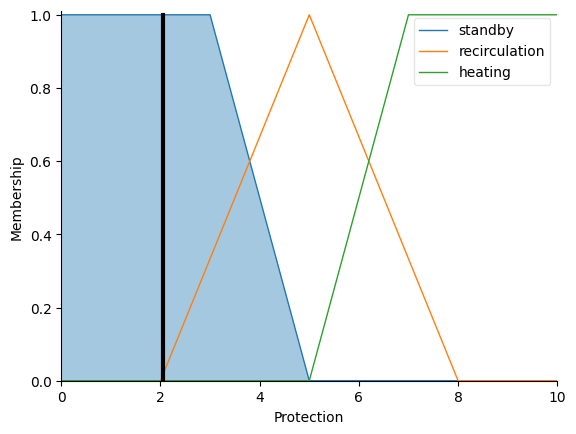

In [191]:
# La temperatura normal (ni frio, ni calor), el etado de carga medio y la red
# neutra, se mantiene en standby sin hacer nada
battery.input['temperature'] = 10
battery.input['soc'] = 50
battery.input['sgrid'] = 0

# Crunch the numbers
battery.compute()

print(battery.output['Protection'])

protection.view(sim=battery)

plt.show()

7.958333333333333


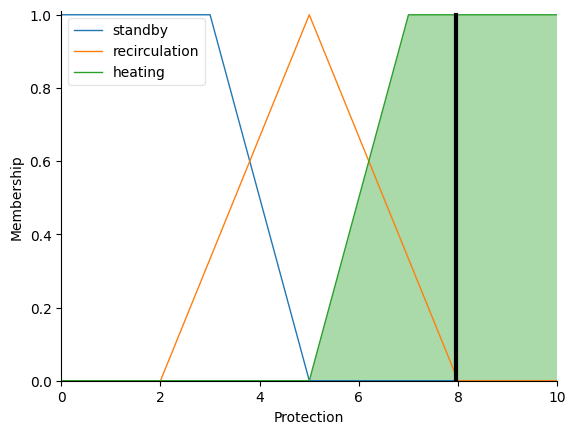

In [193]:
# La temperatura normal (ni frio, ni calor), el etado de la bateria es bajo y la red
# excedente, se aplica carga para calentar
battery.input['temperature'] = -15
battery.input['soc'] = 10
battery.input['sgrid'] = 1

# Crunch the numbers
battery.compute()

print(battery.output['Protection'])

protection.view(sim=battery)

plt.show()